In [6]:
import imageio
import cv2
import subprocess
import librosa
import librosa.display
import soundfile as sf
import os
import torch
from torchvision import transforms
from inference.Inferencer import Inferencer
from models.PasticheModel import PasticheModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from PIL import Image
from pathlib import Path

In [2]:
# setup style transfer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_styles = 16
image_size =512
model_save_dir = "model/pastichemodel-FINAL.pth"
pastichemodel = PasticheModel(num_styles)
inference = Inferencer(pastichemodel,device,image_size)
inference.load_model_weights(model_save_dir)   

In [237]:
# function to transform image
def get_transformation(im, pos, strength=1):
    #im = reference frame
    #pos is float from 0 to 1 that interps between the images
    #strength float 0 to 1 that sets blending between ref and transformed image. strength 1 is 100% transformed
    pos = pos - int(pos)
    style_1 = int(pos*16)
    style_2 = style_1 + 1 if style_1 < 15 else 0
    blend = pos*16 - style_1
    out = np.array(inference.eval_image(im, style_1, style_2, 1-blend))
    shape = np.array(ref_im).shape
    styled = cv2.resize(out, dsize=(shape[1], shape[0]), interpolation=cv2.INTER_NEAREST)
    ref = np.array(ref_im)
    out = np.array(strength * styled + (1-strength) * ref, dtype='uint8')
    return out

15 0 0.9000000000000004


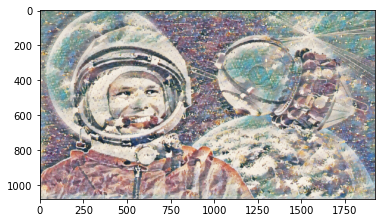

In [236]:
plt.imshow(get_transformation(ref_im, 15.1/16, 1))

[0 1]
(1080, 1920, 3)


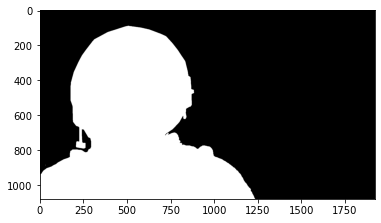

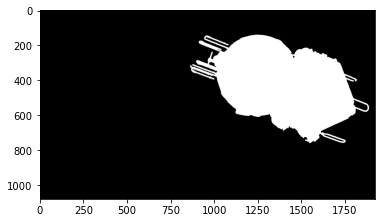

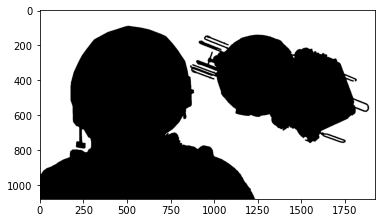

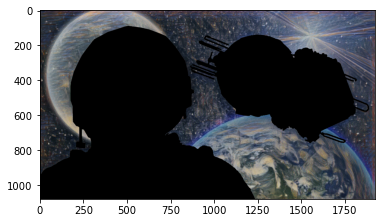

In [149]:
# image paths
im_fold = r"C:\\deep_style_beats\\images\\gegarin\\"
ref_im_path = im_fold+'gregarin.png'
mask_paths = [im_fold+'gag_mask.png',
             im_fold+'vos_mask.png']


#load images and setup masks (masks setup is very ugly but oh well)
ref_im = Image.open(ref_im_path).convert('RGB')
test_im = get_transformation(ref_im, 0.3, strength=0.6)
masks = []
for mp in mask_paths:
    masks.append(np.where(imageio.imread(mp)[:,:,:3]>0,1,0))
masks.append(np.where(masks[0]==1, 1,0))

for m in masks[1:-1]:
    masks[-1] += m
masks[-1] = np.where(masks[-1]==0, 1, 0)
for m in masks:
    plt.imshow(m*255, cmap=plt.cm.gray)
    plt.show()
plt.imshow(test_im*masks[-1])
plt.show()


In [163]:
def get_multi_transformations(im, pos, masks, strength=1):
    if type(strength) is not list:
        strength = [strength for s in range(len(pos))]
    out = get_transformation(im, pos[0], strength=strength[0]) * masks[0]
    for i, p in enumerate(pos[1:]):
        out += get_transformation(im, pos[i+1], strength=strength[i+1]) * masks[i+1]
    return out

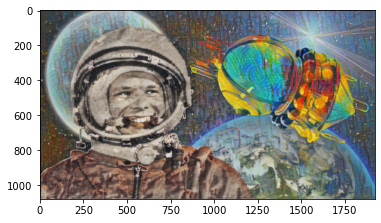

In [164]:
plt.imshow(get_multi_transformations(ref_im, [0.1,0.5, 0.7], masks, strength=[1, 1, 0.5]))

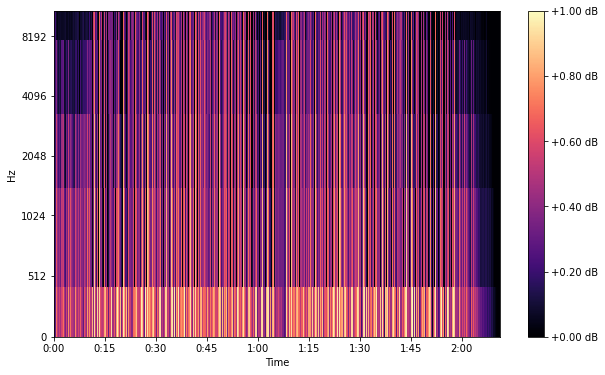

In [179]:
# load audio
audio_data = r'C:\deep_style_beats\audio\Free Range - Mona Wonderlick · [Free Copyright-safe Music].mp3'
z, sr = librosa.load(audio_data, offset = 0.0, duration = None)
out_audio_path = r'C:\deep_style_beats\audio\tmp.wav'
sf.write(out_audio_path, z, sr)
z_harmonic, z_percussive = librosa.effects.hpss(z)
hop_length = 735
Nfft = 2048
n_mels = 5
mel_spect = librosa.feature.melspectrogram(z_percussive, sr=sr, n_fft=Nfft, hop_length=hop_length, n_mels=n_mels)
log_mel_spect= librosa.power_to_db(mel_spect)
norm_mel_spect = (log_mel_spect - log_mel_spect.min()) / (log_mel_spect.max() - log_mel_spect.min())
# Plot the Mel Spectrogram
def mel_grams():
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(norm_mel_spect,
                             x_axis="time",
                             y_axis="mel",
                             sr=sr,
                            hop_length=hop_length)
    plt.colorbar(format="%+2.2f dB")
    plt.show()
mel_grams()

In [167]:
Audio(data=z, rate=sr)

In [238]:
# write video no audio
out_video_path = r'C:\deep_style_beats\video\tmp.avi'
writer = imageio.get_writer(out_video_path, fps=30)
pos3 = 0.66
for i, (sbass, bass, med, treb, utreb) in enumerate(norm_mel_spect.T):
    if i%30 == 0:
        print(i/30)
    pos1 = i/1000 + sbass/16
    pos2 = 0.33 + i/1000 + treb/16
    pos3 += med/300
    pos = [pos1, pos2, pos3]
    im = get_multi_transformations(ref_im, pos, masks, strength=[1, 1, 0.5])
    writer.append_data(np.array(im, dtype='uint8'))
writer.close()

0.0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0


In [239]:
out_path = r'C:\deep_style_beats\video\gegarin.avi'
command = 'ffmpeg -i ' + out_video_path + ' -i ' + out_audio_path + ' -c copy -map 0:v:0 -map 1:a:0 ' + out_path
print(command)
subprocess.call(command, shell=True)

ffmpeg -i C:\deep_style_beats\video\tmp.avi -i C:\deep_style_beats\audio\tmp.wav -c copy -map 0:v:0 -map 1:a:0 C:\deep_style_beats\video\gegarin.avi


0